# Weather Analysis & Forecasting


#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from scipy.stats import zscore
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from xgboost import XGBRegressor
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

sns.set_palette("Set2")

/Users/anusha/miniforge3/envs/notebookenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### loading dataset and initial analysis

In [2]:
df = pd.read_csv('data/GlobalWeatherRepository.csv')
# to display the max number of rows and columns
pd.set_option('display.max_columns', None)
df.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,wind_mph,wind_kph,wind_degree,wind_direction,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feels_like_celsius,feels_like_fahrenheit,visibility_km,visibility_miles,uv_index,gust_mph,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,8.3,13.3,338,NNW,1012.0,29.89,0.0,0.00,24,30,25.3,77.5,10.0,6.0,7.0,9.5,15.3,277.0,103.0,1.1,0.2,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,6.9,11.2,320,NW,1012.0,29.88,0.1,0.00,94,75,19.0,66.2,10.0,6.0,5.0,11.4,18.4,193.6,97.3,0.9,0.1,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,9.4,15.1,280,W,1011.0,29.85,0.0,0.00,29,0,24.6,76.4,10.0,6.0,5.0,13.9,22.3,540.7,12.2,65.1,13.4,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,7.4,11.9,215,SW,1007.0,29.75,0.3,0.01,61,100,3.8,38.9,2.0,1.0,2.0,8.5,13.7,170.2,64.4,1.6,0.2,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,8.1,13.0,150,SSE,1011.0,29.85,0.0,0.00,89,50,28.7,83.6,10.0,6.0,8.0,12.5,20.2,2964.0,19.0,72.7,31.5,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [3]:
# more info
df.shape, df.dtypes

((125306, 41),
 country                          object
 location_name                    object
 latitude                        float64
 longitude                       float64
 timezone                         object
 last_updated_epoch                int64
 last_updated                     object
 temperature_celsius             float64
 temperature_fahrenheit          float64
 condition_text                   object
 wind_mph                        float64
 wind_kph                        float64
 wind_degree                       int64
 wind_direction                   object
 pressure_mb                     float64
 pressure_in                     float64
 precip_mm                       float64
 precip_in                       float64
 humidity                          int64
 cloud                             int64
 feels_like_celsius              float64
 feels_like_fahrenheit           float64
 visibility_km                   float64
 visibility_miles                float64
 

In [4]:
df.columns

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')

In [5]:
# Missing values 
df.isnull().values.any()

np.False_

#### Parsing datetime

In [6]:
df['last_updated'] = pd.to_datetime(df['last_updated'])
df['date'] = df['last_updated'].dt.date
df['month'] = df['last_updated'].dt.month
df['day_of_week'] = df['last_updated'].dt.dayofweek
df['hour'] = df['last_updated'].dt.hour

df['sunrise'] = pd.to_datetime(df['sunrise'], errors='coerce')
df['sunset'] = pd.to_datetime(df['sunset'], errors='coerce')
df['moonrise'] = pd.to_datetime(df['moonrise'], errors='coerce')
df['moonset'] = pd.to_datetime(df['moonset'], errors='coerce')

print(f"Date range: {df['last_updated'].min()} to {df['last_updated'].max()}")

Date range: 2024-05-16 01:45:00 to 2026-02-20 20:00:00


## Exploratory Data Analysis


#### Temperature Analysis

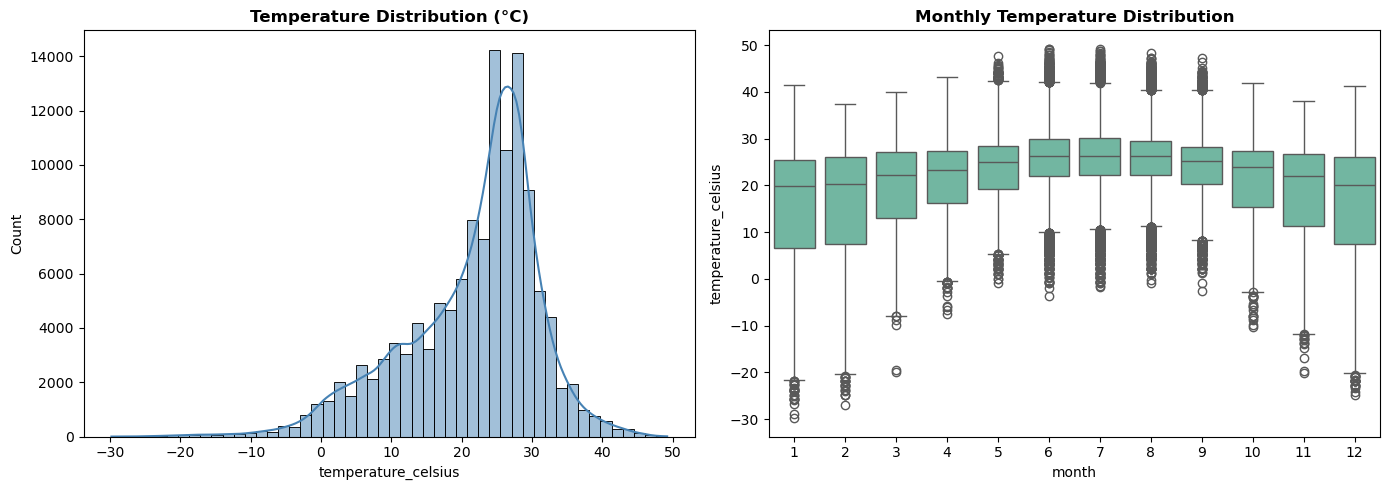

In [7]:
# Global temperature distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['temperature_celsius'], bins=50, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Temperature Distribution (°C)', fontweight='bold')

sns.boxplot(x='month', y='temperature_celsius', data=df, ax=axes[1])
axes[1].set_title('Monthly Temperature Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

#### Precipitation Analysis

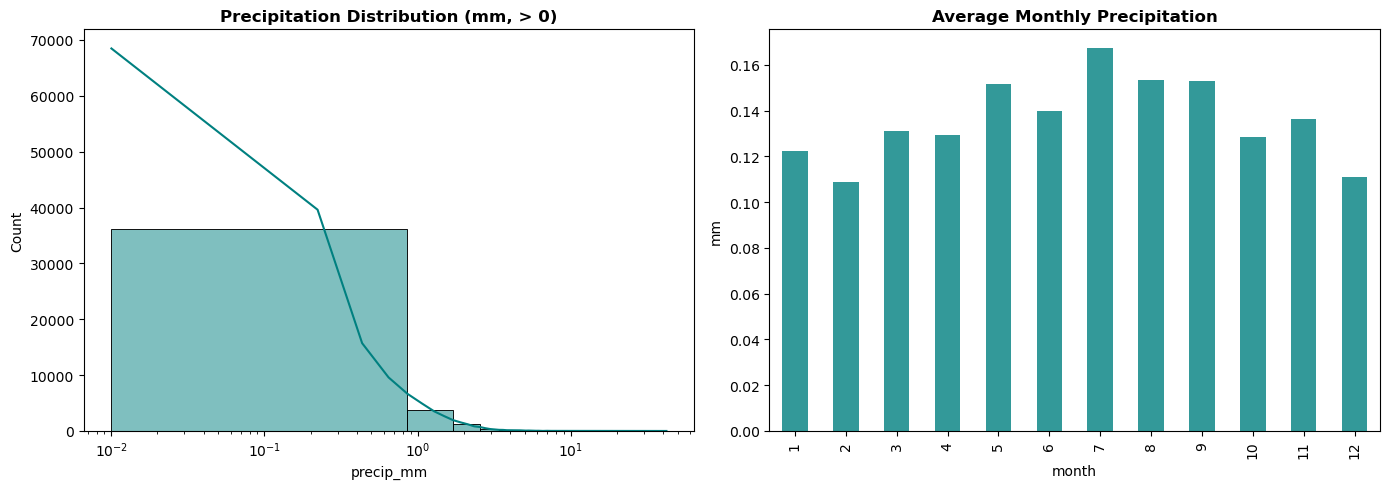

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precipitation distribution (log scale for skewed data)
sns.histplot(df['precip_mm'][df['precip_mm'] > 0], bins=50, kde=True, ax=axes[0], color='teal')
axes[0].set_title('Precipitation Distribution (mm, > 0)', fontweight='bold')
axes[0].set_xscale('log')

# Monthly precipitation
monthly_precip = df.groupby('month')['precip_mm'].mean()
monthly_precip.plot(kind='bar', ax=axes[1], color='teal', alpha=0.8)
axes[1].set_title('Average Monthly Precipitation', fontweight='bold')
axes[1].set_ylabel('mm')

plt.tight_layout()
plt.show()

Time series: 645 days


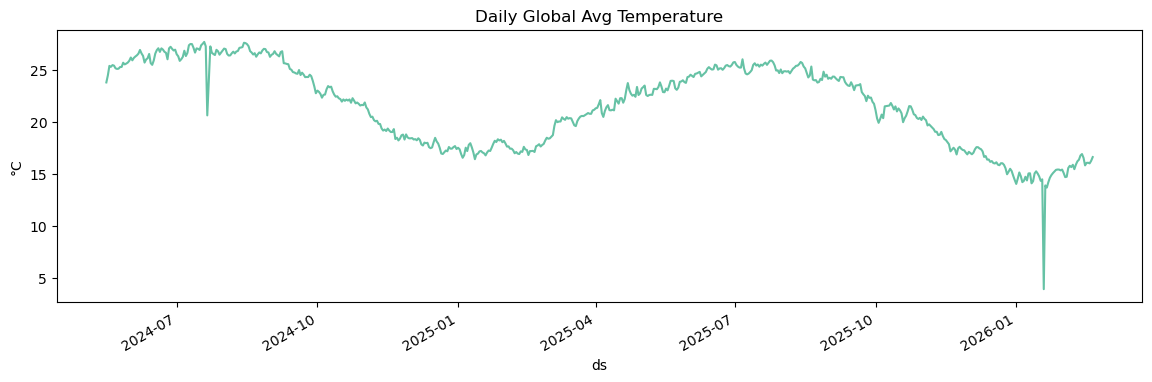

In [9]:
# Prepare time series: daily average temperature globally
ts = df.groupby(df['last_updated'].dt.date)['temperature_celsius'].mean().reset_index()
ts.columns = ['ds', 'y']
ts['ds'] = pd.to_datetime(ts['ds'])
ts = ts.sort_values('ds').reset_index(drop=True)

# --- OUTLIER CORRECTION FOR TIME SERIES ---
# 1. Identify the dips (values significantly lower than the local average)
ts['rolling_med'] = ts['y'].rolling(window=7, center=True).median()
ts['std'] = ts['y'].rolling(window=7, center=True).std()

# 2. Flag values that are more than 3 standard deviations below the median
# (Focusing on the 'dips' specifically)
outlier_mask = (ts['y'] < ts['rolling_med'] - (3 * ts['std']))

# 3. Replace outliers with NaN and interpolate
ts.loc[outlier_mask, 'y'] = np.nan
ts['y'] = ts['y'].interpolate(method='linear')

# Add this to catch any NaNs at the very edges of the dataset
ts['y'] = ts['y'].ffill().bfill() 


# Clean up helper columns
ts = ts.drop(columns=['rolling_med', 'std'])

print(f"Time series: {len(ts)} days")
ts.plot(x='ds', y='y', figsize=(14, 4), title='Daily Global Avg Temperature', legend=False)
plt.ylabel('°C')
plt.show()

### Correlation Analysis (for separate feature groups)

#### 1. weather group

In [10]:
weather_cols = [
    'temperature_celsius','temperature_fahrenheit',
    'wind_mph','wind_kph','wind_degree',
    'pressure_mb','pressure_in',
    'precip_mm','precip_in',
    'humidity','cloud',
    'feels_like_celsius','feels_like_fahrenheit',
    'visibility_km','visibility_miles',
    'uv_index','gust_mph','gust_kph'
]

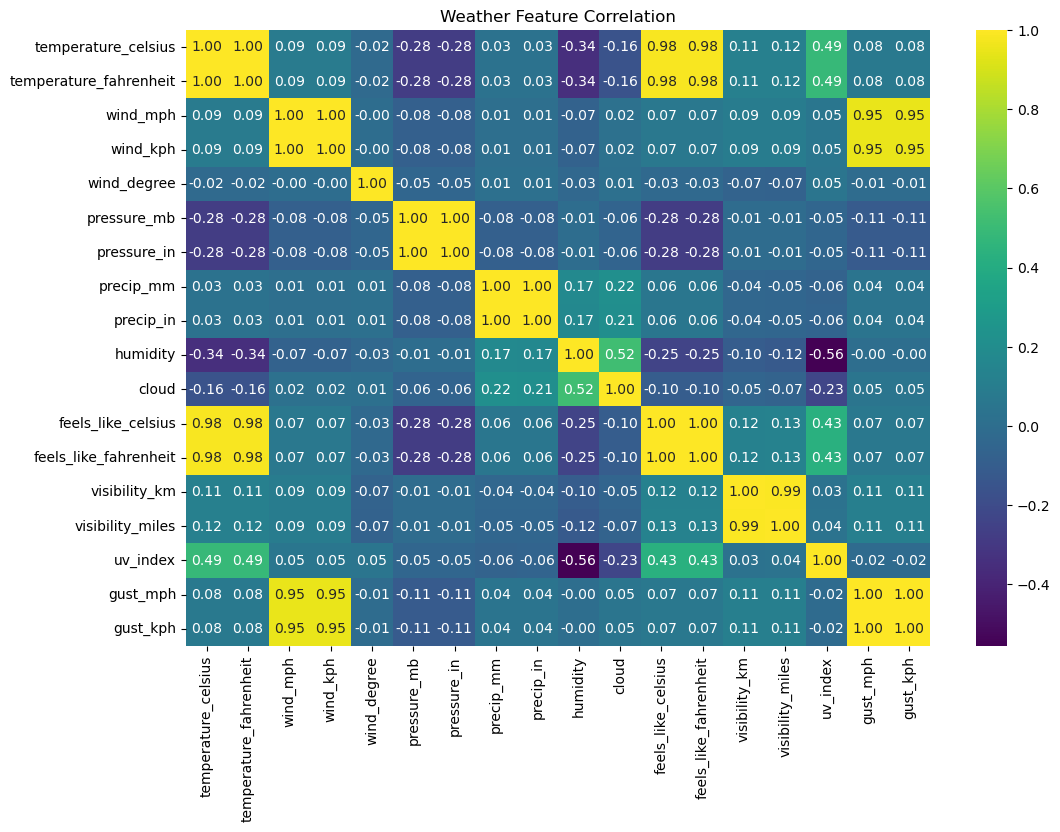

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(df[weather_cols].corr(), annot=True, cmap="viridis", fmt=".2f")
plt.title("Weather Feature Correlation")
plt.show()

#### 2. Air quality group

In [12]:
air_cols = ['air_quality_Carbon_Monoxide','air_quality_Ozone','air_quality_Nitrogen_dioxide','air_quality_Sulphur_dioxide','air_quality_PM2.5',
            'air_quality_PM10','air_quality_us-epa-index','air_quality_gb-defra-index']

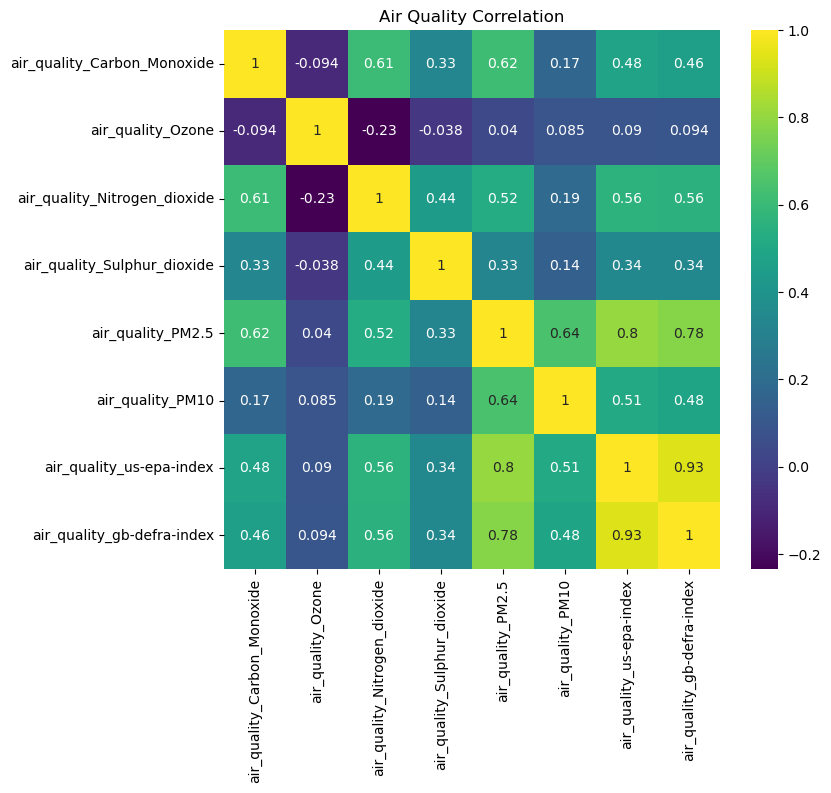

In [13]:
plt.figure(figsize=(8,7))
sns.heatmap(df[air_cols].corr(), annot=True, cmap='viridis')
plt.title("Air Quality Correlation")
plt.show()

There is an almost perfect correlation between temperature_celsius & temperature_fahrenheit, wind_mph & wind_kph, pressure_mb & pressure_in, precip_mm & precip_in, feels_like_celsius & feels_like_fahrenheit, visibility_km & visibility_miles and gust_mph & gust_kph

These are redundant, so let's drop one from each pair before modeling.

In [14]:
cols_to_drop = [
    'temperature_fahrenheit',
    'wind_mph',
    'pressure_in',
    'precip_in',
    'feels_like_fahrenheit',
    'visibility_miles',
    'gust_mph',
    'last_updated_epoch'  # not useful for modeling
]

df = df.drop(columns=cols_to_drop, errors='ignore')

df.head()   


,country,location_name,latitude,longitude,timezone,last_updated,temperature_celsius,condition_text,wind_kph,wind_degree,wind_direction,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination,date,month,day_of_week,hour
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,2024-05-16 13:15:00,26.6,Partly Cloudy,13.3,338,NNW,1012.0,0.0,24,30,25.3,10.0,7.0,15.3,277.0,103.0,1.1,0.2,8.4,26.6,1,1,2026-02-21 04:50:00,2026-02-21 18:50:00,2026-02-21 12:12:00,2026-02-21 01:11:00,Waxing Gibbous,55,2024-05-16,5,3,13
1,Albania,Tirana,41.33,19.82,Europe/Tirane,2024-05-16 10:45:00,19.0,Partly cloudy,11.2,320,NW,1012.0,0.1,94,75,19.0,10.0,5.0,18.4,193.6,97.3,0.9,0.1,1.1,2.0,1,1,2026-02-21 05:21:00,2026-02-21 19:54:00,2026-02-21 12:58:00,2026-02-21 02:14:00,Waxing Gibbous,55,2024-05-16,5,3,10
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,2024-05-16 09:45:00,23.0,Sunny,15.1,280,W,1011.0,0.0,29,0,24.6,10.0,5.0,22.3,540.7,12.2,65.1,13.4,10.4,18.4,1,1,2026-02-21 05:40:00,2026-02-21 19:50:00,2026-02-21 13:15:00,2026-02-21 02:14:00,Waxing Gibbous,55,2024-05-16,5,3,9
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,2024-05-16 10:45:00,6.3,Light drizzle,11.9,215,SW,1007.0,0.3,61,100,3.8,2.0,2.0,13.7,170.2,64.4,1.6,0.2,0.7,0.9,1,1,2026-02-21 06:31:00,2026-02-21 21:11:00,2026-02-21 14:12:00,2026-02-21 03:31:00,Waxing Gibbous,55,2024-05-16,5,3,10
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,2024-05-16 09:45:00,26.0,Partly cloudy,13.0,150,SSE,1011.0,0.0,89,50,28.7,10.0,8.0,20.2,2964.0,19.0,72.7,31.5,183.4,262.3,5,10,2026-02-21 06:12:00,2026-02-21 17:55:00,2026-02-21 13:17:00,2026-02-21 00:38:00,Waxing Gibbous,55,2024-05-16,5,3,9


### Outlier detection & handling using z-score

In [15]:
# checking skewness
df.select_dtypes(include='number').skew().sort_values(ascending=False)

wind_kph                        123.850355
pressure_mb                     105.452920
gust_kph                         75.598119
precip_mm                        17.666512
air_quality_PM10                 16.761518
air_quality_Carbon_Monoxide      12.984209
air_quality_PM2.5                 8.966905
air_quality_Nitrogen_dioxide      3.143982
air_quality_gb-defra-index        1.969345
air_quality_us-epa-index          1.519408
air_quality_Ozone                 1.241875
visibility_km                     1.073923
uv_index                          0.849801
cloud                             0.230596
wind_degree                       0.175337
hour                              0.065190
moon_illumination                 0.020116
longitude                         0.006709
day_of_week                      -0.004267
month                            -0.241054
latitude                         -0.305021
humidity                         -0.621975
feels_like_celsius               -0.876462
temperature

there is a lot of skew, so we need to do outlier handling.


In [ ]:
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
z_scores = df[numeric_features].apply(zscore)

# outliers: z-score > 3 
outliers = (z_scores.abs() > 3).sum()
print(outliers.sort_values(ascending=False))

visibility_km                   3825
air_quality_Nitrogen_dioxide    3134
air_quality_PM2.5               1932
precip_mm                       1764
air_quality_Carbon_Monoxide     1694
air_quality_us-epa-index        1584
air_quality_Ozone               1341
air_quality_PM10                1229
air_quality_Sulphur_dioxide     1154
feels_like_celsius               954
temperature_celsius              922
uv_index                         531
gust_kph                         513
wind_kph                         198
pressure_mb                      129
air_quality_gb-defra-index         0
latitude                           0
longitude                          0
cloud                              0
humidity                           0
wind_degree                        0
moon_illumination                  0
dtype: int64


In [17]:
filtered_df = df[(z_scores.abs() <= 3).all(axis=1)]

print(f"Original dataset size: {df.shape[0]} rows")
print(f"Dataset size after removing outliers: {filtered_df.shape[0]} rows")

Original dataset size: 125306 rows
Dataset size after removing outliers: 111159 rows


In [18]:
df = filtered_df

#### Weather Conditions Overview

In [19]:
# Top weather conditions
fig = px.pie(df['condition_text'].value_counts().head(10).reset_index(),
             names='condition_text', values='count',
             title='Top 10 Weather Conditions Worldwide')
fig.show()

### Environmental Impact - Air Quality Analysis

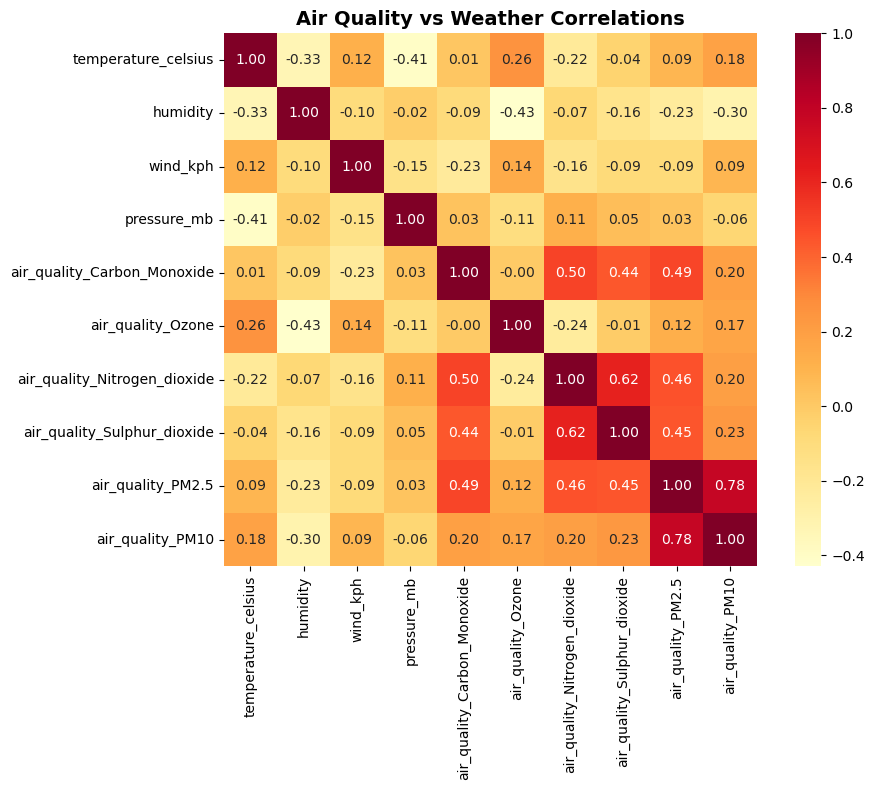

In [20]:
# Air quality columns
aq_cols = ['air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
           'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10']

# Correlation between air quality and weather
weather_aq = ['temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb'] + aq_cols

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df[weather_aq].corr(), annot=True, fmt='.2f', cmap='YlOrRd', ax=ax, square=True)
ax.set_title('Air Quality vs Weather Correlations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### Top polluted countries by PM2.5


In [21]:
pollution = df.groupby('country')['air_quality_PM2.5'].mean().nlargest(20)

fig = px.bar(pollution.reset_index(), x='country', y='air_quality_PM2.5',
             title='Top 20 Most Polluted Countries (Avg PM2.5)',
             color='air_quality_PM2.5', color_continuous_scale='Reds')
fig.show()

#### Temperature effect on air quality


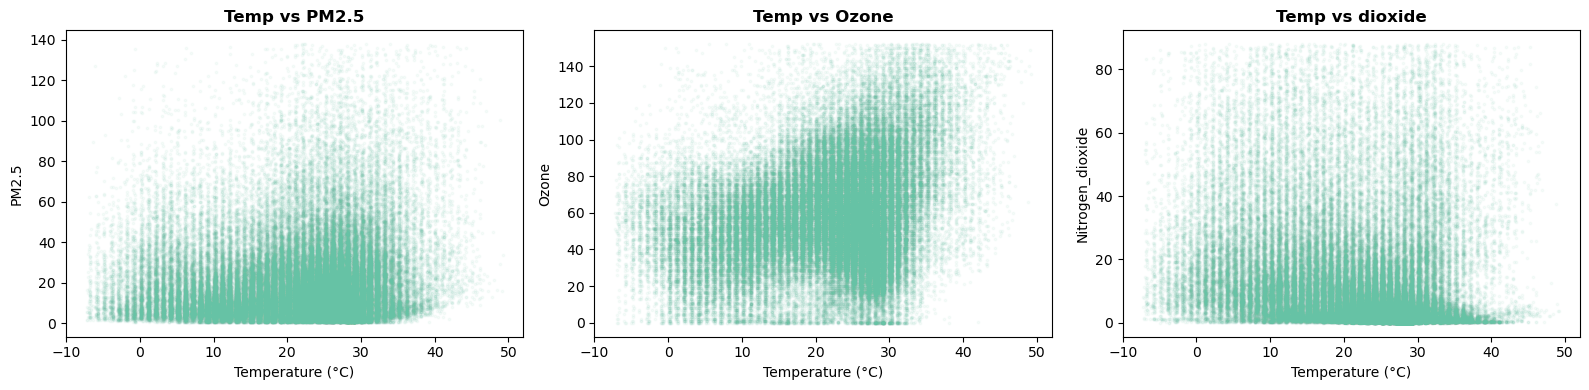

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, pollutant in zip(axes, ['air_quality_PM2.5', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide']):
    ax.scatter(df['temperature_celsius'], df[pollutant], alpha=0.05, s=3)
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel(pollutant.replace('air_quality_', ''))
    ax.set_title(f'Temp vs {pollutant.split("_")[-1]}', fontweight='bold')

plt.tight_layout()
plt.show()

###  Advanced EDA - Anomaly Detection

In [23]:
# Isolation Forest for anomaly detection

anomaly_features = ['temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb', 'precip_mm']
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso_forest.fit_predict(df[anomaly_features])

print(f"Normal: {(df['anomaly'] == 1).sum()}, Anomalies: {(df['anomaly'] == -1).sum()}")

Normal: 105601, Anomalies: 5558


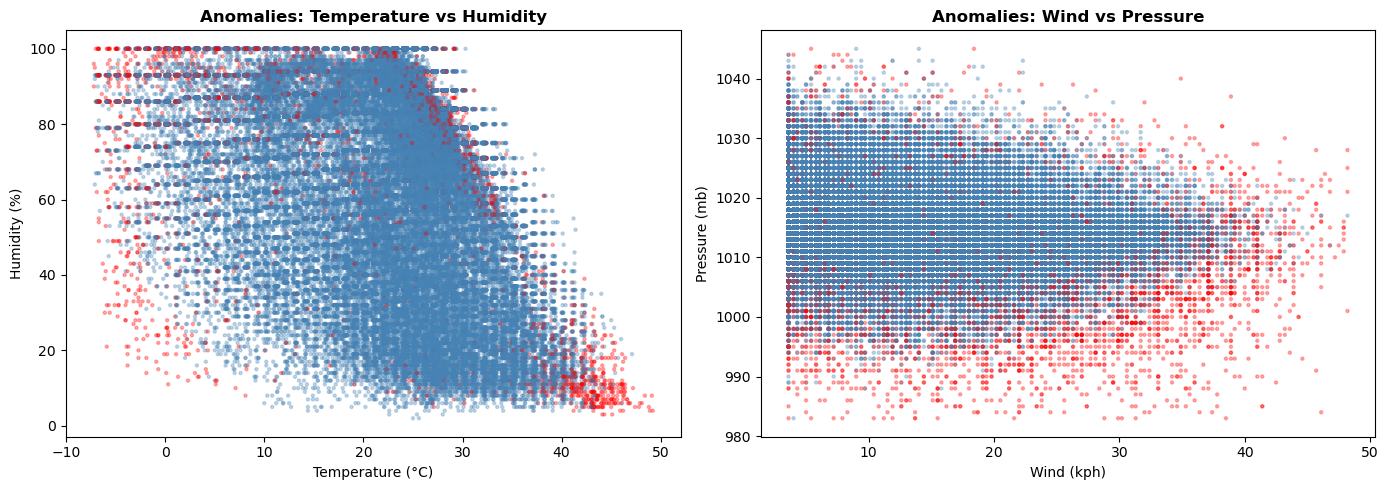

In [24]:
# Visualize anomalies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = df['anomaly'].map({1: 'steelblue', -1: 'red'})
axes[0].scatter(df['temperature_celsius'], df['humidity'], c=colors, alpha=0.3, s=5)
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Humidity (%)')
axes[0].set_title('Anomalies: Temperature vs Humidity', fontweight='bold')

axes[1].scatter(df['wind_kph'], df['pressure_mb'], c=colors, alpha=0.3, s=5)
axes[1].set_xlabel('Wind (kph)')
axes[1].set_ylabel('Pressure (mb)')
axes[1].set_title('Anomalies: Wind vs Pressure', fontweight='bold')

plt.tight_layout()
plt.show()

In [25]:
# Z-Score based anomaly detection on temperature

df['temp_zscore'] = np.abs(stats.zscore(df['temperature_celsius']))
z_anomalies = df[df['temp_zscore'] > 3]
print(f"Z-Score anomalies (|z| > 3): {len(z_anomalies)}")

fig = px.scatter(df.sample(5000, random_state=42), x='temperature_celsius', y='humidity',
                 color=df.sample(5000, random_state=42)['temp_zscore'] > 3,
                 title='Z-Score Anomalies in Temperature',
                 labels={'color': 'Anomaly'})
fig.show()

Z-Score anomalies (|z| > 3): 292


## Unique Analysis

### Spatial Analysis & Geographical Patterns

#### Global temperature map


In [26]:
city_avg = df.groupby(['location_name', 'latitude', 'longitude', 'country']).agg(
    avg_temp=('temperature_celsius', 'mean'),
    avg_humidity=('humidity', 'mean'),
    avg_pm25=('air_quality_PM2.5', 'mean')
).reset_index()

fig = px.scatter_geo(city_avg, lat='latitude', lon='longitude', color='avg_temp',
                     hover_name='location_name', size=np.abs(city_avg['avg_temp']) + 5,
                     color_continuous_scale='RdYlBu_r',
                     title='Global Temperature Map')
fig.show()

In [27]:
# Global humidity map
fig = px.scatter_geo(city_avg, lat='latitude', lon='longitude', color='avg_humidity',
                     hover_name='location_name', size='avg_humidity',
                     color_continuous_scale='Blues',
                     title='Global Humidity Map')
fig.show()

In [28]:
# Air quality global map (PM2.5)
fig = px.scatter_geo(city_avg, lat='latitude', lon='longitude', color='avg_pm25',
                     hover_name='location_name', size='avg_pm25',
                     color_continuous_scale='YlOrRd',
                     title='Global Air Quality Map (PM2.5)')
fig.show()

In [29]:
# Country-level comparison
country_stats = df.groupby('country').agg(
    avg_temp=('temperature_celsius', 'mean'),
    avg_humidity=('humidity', 'mean'),
    avg_wind=('wind_kph', 'mean'),
    avg_precip=('precip_mm', 'mean')
).reset_index()

fig = px.choropleth(country_stats, locations='country', locationmode='country names',
                    color='avg_temp', color_continuous_scale='RdYlBu_r',
                    title='Average Temperature by Country',
                    labels={'avg_temp': 'Avg Temp (°C)'})
fig.show()

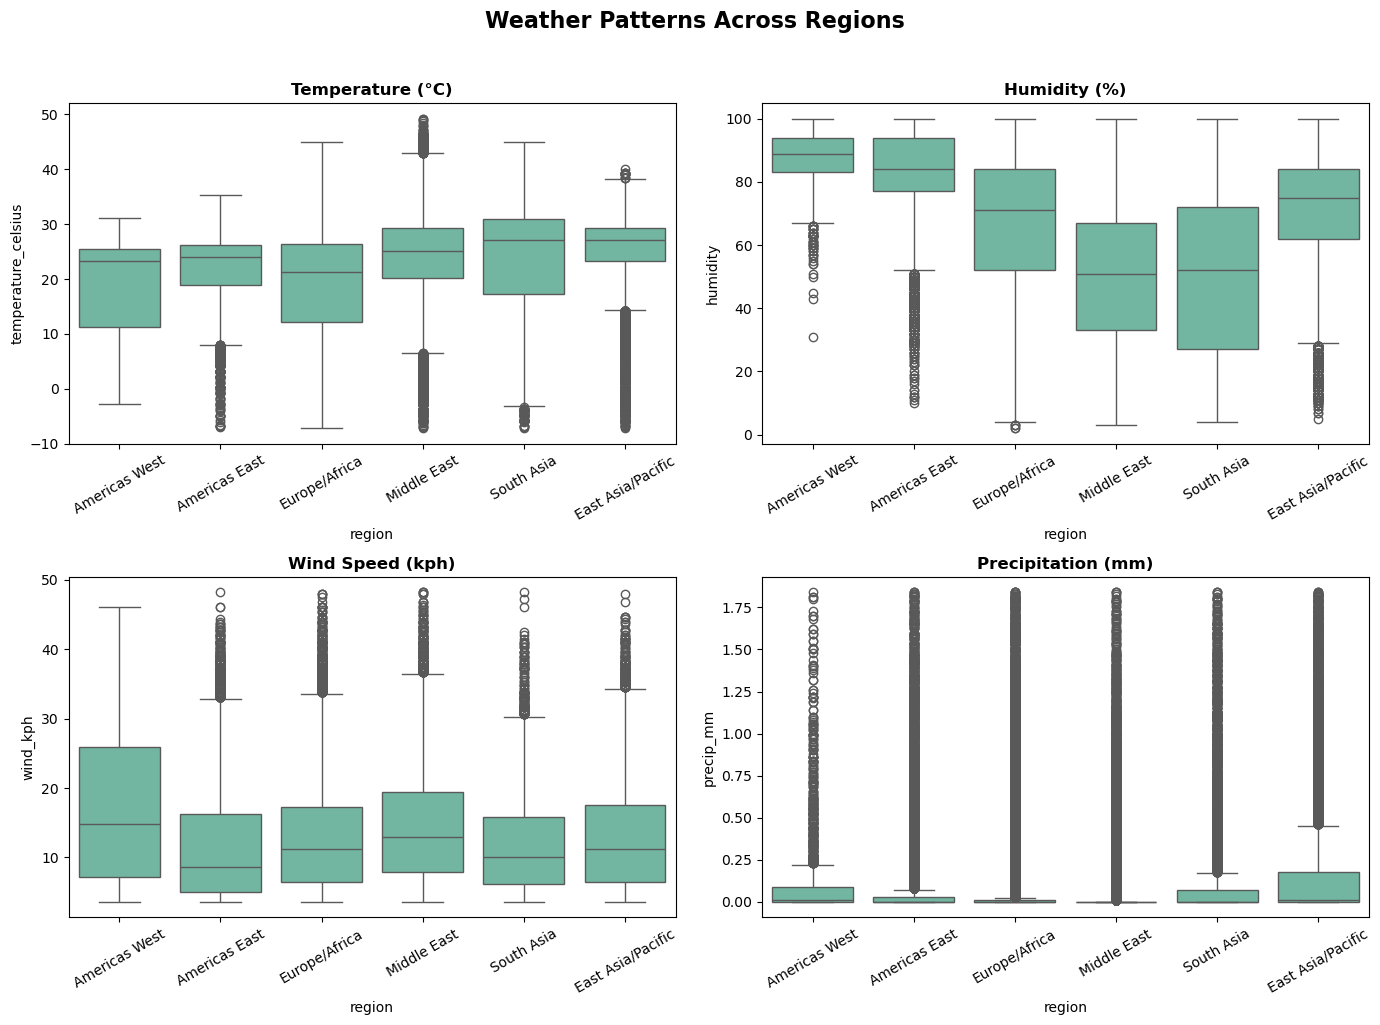

In [30]:
# Weather conditions differ across continents (approximated by longitude bands)
df['region'] = pd.cut(df['longitude'],
                      bins=[-180, -100, -30, 30, 60, 100, 180],
                      labels=['Americas West', 'Americas East', 'Europe/Africa',
                              'Middle East', 'South Asia', 'East Asia/Pacific'])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, col, title in zip(axes.flat,
    ['temperature_celsius', 'humidity', 'wind_kph', 'precip_mm'],
    ['Temperature (°C)', 'Humidity (%)', 'Wind Speed (kph)', 'Precipitation (mm)']):
    sns.boxplot(data=df, x='region', y=col, ax=ax)
    ax.set_title(title, fontweight='bold')
    ax.tick_params(axis='x', rotation=30)

plt.suptitle('Weather Patterns Across Regions', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [31]:
# Wind patterns across regions
wind_by_dir = df.groupby(['region', 'wind_direction']).size().reset_index(name='count')
top_regions = df['region'].value_counts().head(4).index

fig = px.bar_polar(wind_by_dir[wind_by_dir['region'].isin(top_regions)],
                   r='count', theta='wind_direction', color='region',
                   title='Wind Direction by Region')
fig.show()


### Climate Analysis

In [32]:
# Climate variability: std dev of temperature by country
climate_var = df.groupby('country')['temperature_celsius'].agg(['mean', 'std']).dropna()
climate_var = climate_var.sort_values('std', ascending=False).head(20)

fig = px.bar(climate_var.reset_index(), x='country', y='std', color='mean',
             title='Top 20 Countries by Temperature Variability',
             labels={'std': 'Std Dev (°C)', 'mean': 'Mean Temp (°C)'})
fig.show()

### Feature Importance 

In [ ]:
# Features & target
feature_cols = [
    'humidity','wind_kph','pressure_mb','precip_mm','cloud',
    'uv_index','visibility_km','gust_kph','latitude','longitude',
    'air_quality_PM2.5','air_quality_Ozone'
]

X = df[feature_cols].dropna()
y = df.loc[X.index, 'temperature_celsius']

# Models
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf.fit(X, y)
xgb.fit(X, y)

X_sample = X.sample(5000, random_state=42)
y_sample = y.loc[X_sample.index]

perm = permutation_importance(rf, X_sample, y_sample,
                              n_repeats=10, random_state=42)

# Combine normalized importances
fi_compare = pd.DataFrame({
    'Random Forest': rf.feature_importances_,
    'XGBoost': xgb.feature_importances_,
    'Permutation': perm.importances_mean
}, index=feature_cols)

fi_compare = fi_compare.div(fi_compare.sum()).sort_values('Random Forest')

# Plot
fi_compare.plot.barh(figsize=(10,6))
plt.title('Feature Importance Comparison (Normalized)', fontweight='bold')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

Latitude and UV index are the most important features, indicating strong geographical and solar influence on the target. 

Pressure has moderate importance, while humidity and longitude contribute slightly. 

Wind, precipitation, visibility, and pollutant variables have relatively low impact. 


# Forecasting 

In [ ]:
split = int(len(ts) * 0.85)
train, test = ts.iloc[:split], ts.iloc[split:]

y_train = train['y'].values
y_test = test['y'].values

In [ ]:
# Evaluation helper

def evaluate(actual, predicted, name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    print(f"{name:20s} | MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

results = []


#### Prophet model (with seasonality enabled)

02:37:19 - cmdstanpy - INFO - Chain [1] start processing
02:37:20 - cmdstanpy - INFO - Chain [1] done processing


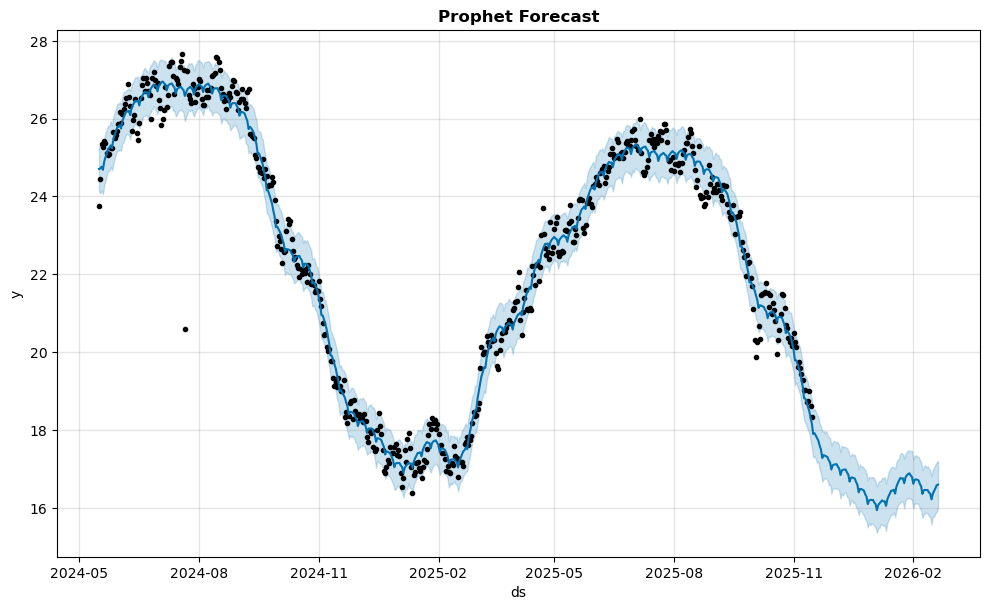

Prophet              | MAE: 1.036 | RMSE: 1.731 | R²: -0.117


In [ ]:

model_prophet = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True)
model_prophet.fit(train)

future = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future)
pred_prophet = forecast_prophet.tail(len(test))['yhat'].values

model_prophet.plot(forecast_prophet)
plt.title('Prophet Forecast', fontweight='bold')
plt.show()

results.append(evaluate(y_test, pred_prophet, "Prophet"))


#### ARIMA Model


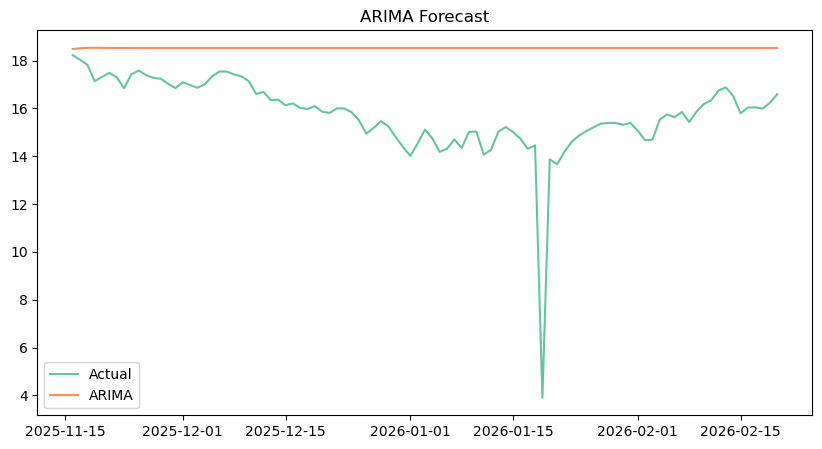

ARIMA(5,1,2)         | MAE: 2.775 | RMSE: 3.222 | R²: -2.872


In [ ]:
model_arima = ARIMA(train['y'], order=(5,1,2))
fit_arima = model_arima.fit()

pred_arima = fit_arima.forecast(steps=len(test))

# Plot
plt.figure(figsize=(10,5))
plt.plot(test['ds'], test['y'].values, label='Actual')
plt.plot(test['ds'], pred_arima, label='ARIMA')
plt.title("ARIMA Forecast")
plt.legend()
plt.show()

results.append(evaluate(test['y'].values, pred_arima, "ARIMA(5,1,2)"))

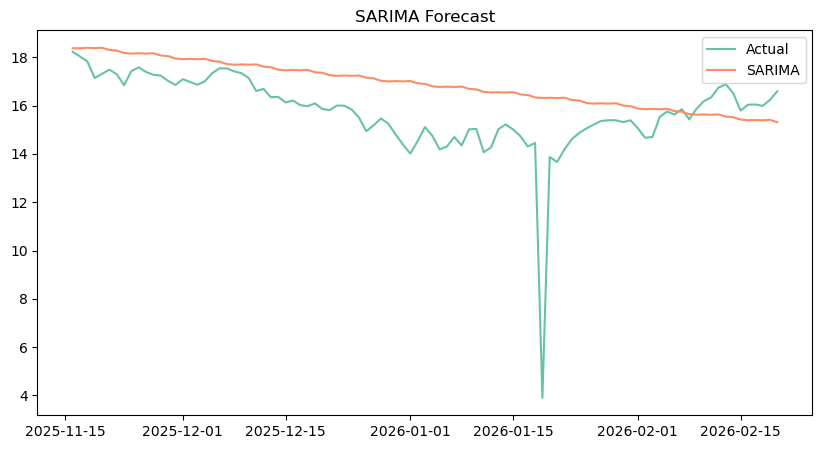

SARIMA               | MAE: 1.328 | RMSE: 1.875 | R²: -0.311


In [ ]:
sarima = SARIMAX(
    y_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7)
)

sarima_fit = sarima.fit(disp=False)
pred_sarima = sarima_fit.forecast(steps=len(y_test))

plt.figure(figsize=(10,5))
plt.plot(test['ds'], y_test, label='Actual')
plt.plot(test['ds'], pred_sarima, label='SARIMA')
plt.title("SARIMA Forecast")
plt.legend()
plt.show()

results.append(evaluate(y_test, pred_sarima, "SARIMA"))

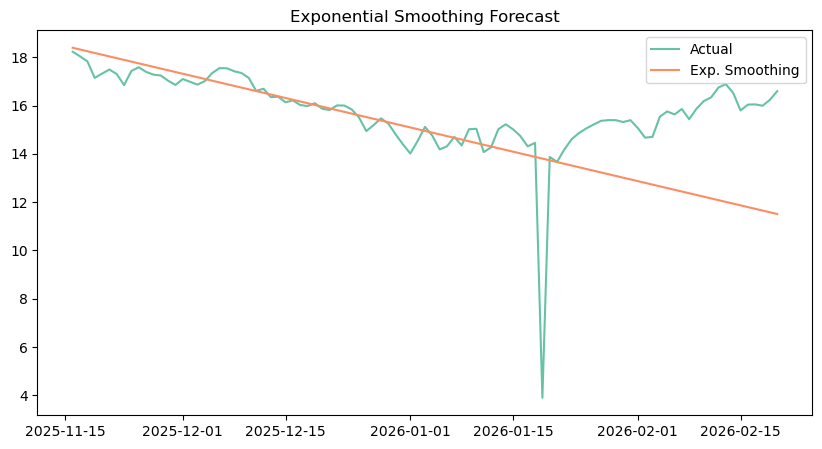

Exp. Smoothing       | MAE: 1.306 | RMSE: 2.133 | R²: -0.697


In [ ]:
model_ets = ExponentialSmoothing(
    train['y'],
    trend='add',
    seasonal=None
)

fit_ets = model_ets.fit()
pred_ets = fit_ets.forecast(len(test))

plt.figure(figsize=(10,5))
plt.plot(test['ds'], test['y'].values, label='Actual')
plt.plot(test['ds'], pred_ets, label='Exp. Smoothing')
plt.title("Exponential Smoothing Forecast")
plt.legend()
plt.show()

results.append(evaluate(test['y'].values, pred_ets, "Exp. Smoothing"))

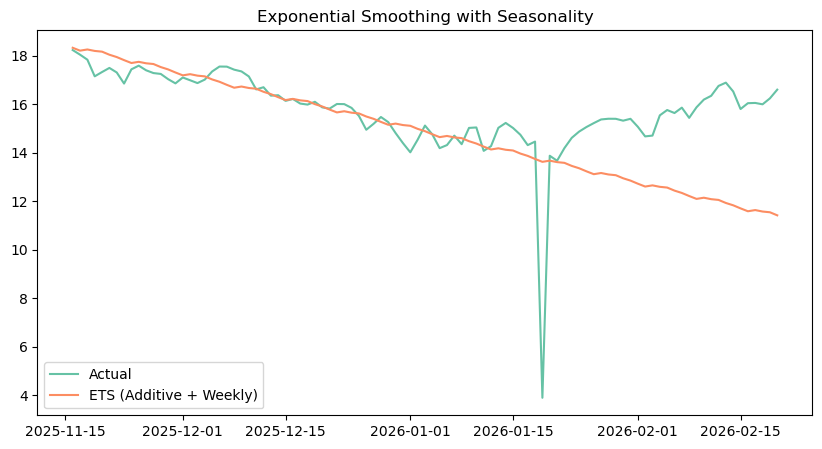

ETS (Add+Seasonal)   | MAE: 1.336 | RMSE: 2.169 | R²: -0.755


In [ ]:
# Refit ETS with seasonal component
model_ets = ExponentialSmoothing(
    train['y'],
    trend='add',
    seasonal='add',
    seasonal_periods=7
)

fit_ets = model_ets.fit(optimized=True)

# Forecast
pred_ets = fit_ets.forecast(len(test))

# Plot
plt.figure(figsize=(10,5))
plt.plot(test['ds'], test['y'].values, label='Actual')
plt.plot(test['ds'], pred_ets, label='ETS (Additive + Weekly)')
plt.title("Exponential Smoothing with Seasonality")
plt.legend()
plt.show()

# Evaluate
results.append(evaluate(test['y'].values, pred_ets, "ETS (Add+Seasonal)"))

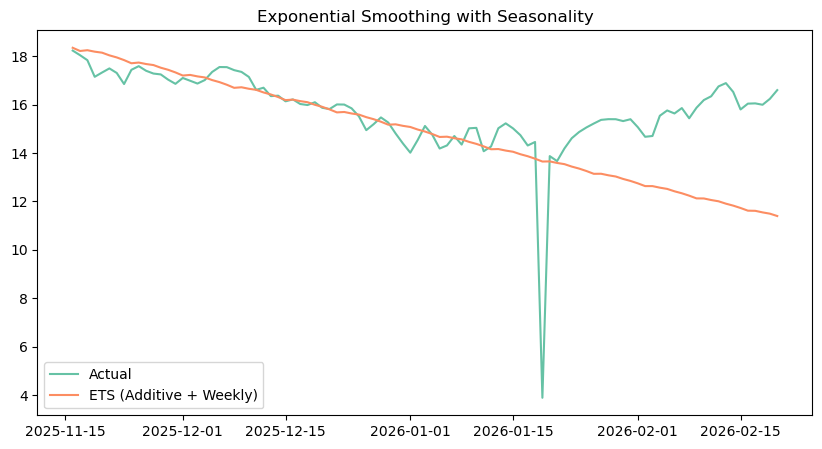

ETS (Mult+Seasonal)  | MAE: 1.337 | RMSE: 2.174 | R²: -0.763


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import matplotlib.pyplot as plt

# Refit ETS with seasonal component
model_ets = ExponentialSmoothing(
    train['y'],
    trend='add',
    seasonal='mul',
    seasonal_periods=7
)

fit_ets = model_ets.fit(optimized=True)

# Forecast
pred_ets = fit_ets.forecast(len(test))

# Plot
plt.figure(figsize=(10,5))
plt.plot(test['ds'], test['y'].values, label='Actual')
plt.plot(test['ds'], pred_ets, label='ETS (Additive + Weekly)')
plt.title("Exponential Smoothing with Seasonality")
plt.legend()
plt.show()

# Evaluate
results.append(evaluate(test['y'].values, pred_ets, "ETS (Mult+Seasonal)"))

### Random Forest

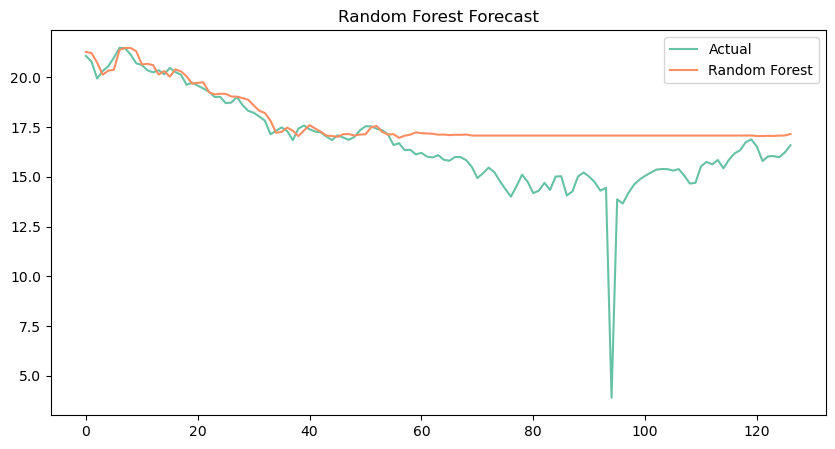

Random Forest        | MAE: 1.177 | RMSE: 1.848 | R²: 0.379


In [ ]:
def create_lags(series, lags=14):
    df_lag = pd.DataFrame({'y': series})
    for i in range(1, lags + 1):
        df_lag[f'lag_{i}'] = df_lag['y'].shift(i)
    return df_lag.dropna()

ts_lag = create_lags(ts['y'], lags=14)

split_lag = int(len(ts_lag) * 0.8)
train_lag, test_lag = ts_lag.iloc[:split_lag], ts_lag.iloc[split_lag:]

X_train, y_train_lag = train_lag.drop('y', axis=1), train_lag['y']
X_test, y_test_lag = test_lag.drop('y', axis=1), test_lag['y']

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train_lag)
pred_rf = rf.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(y_test_lag.values, label='Actual')
plt.plot(pred_rf, label='Random Forest')
plt.title("Random Forest Forecast")
plt.legend()
plt.show()

results.append(evaluate(y_test_lag.values, pred_rf, "Random Forest"))

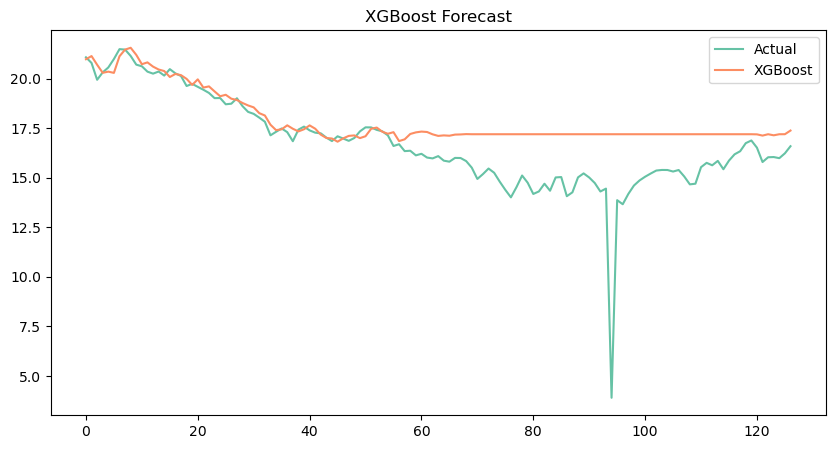

XGBoost              | MAE: 1.232 | RMSE: 1.912 | R²: 0.335


In [ ]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb.fit(X_train, y_train_lag)
pred_xgb = xgb.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(y_test_lag.values, label='Actual')
plt.plot(pred_xgb, label='XGBoost')
plt.title("XGBoost Forecast")
plt.legend()
plt.show()

results.append(evaluate(y_test_lag.values, pred_xgb, "XGBoost"))

#### Summary & Final Results

FORECASTING MODEL RESULTS
              Model      MAE     RMSE        R2
            Prophet 1.036357 1.730770 -0.117098
       ARIMA(5,1,2) 2.774919 3.222389 -2.872292
             SARIMA 1.327900 1.874981 -0.311010
     Exp. Smoothing 1.306416 2.132988 -0.696637
 ETS (Add+Seasonal) 1.336235 2.169273 -0.754852
ETS (Mult+Seasonal) 1.337269 2.174123 -0.762709
      Random Forest 1.177486 1.847621  0.378798
            XGBoost 1.231689 1.911673  0.334981

Best by MAE  : Prophet
Best by RMSE : Prophet
Best by R²   : Random Forest


<Figure size 1000x500 with 0 Axes>

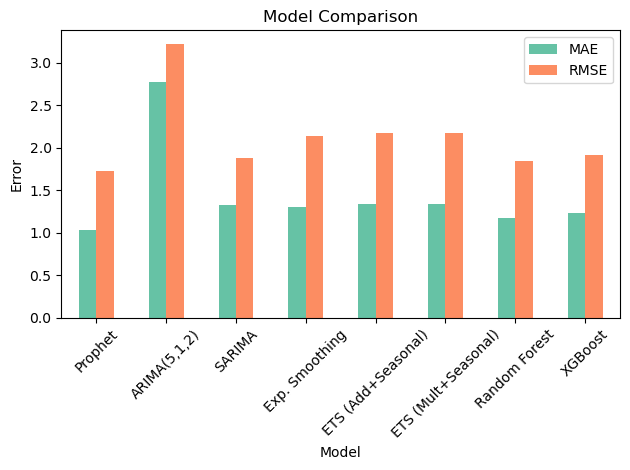

In [ ]:
results_df = pd.DataFrame(results)

print("=" * 70)
print("FORECASTING MODEL RESULTS")
print("=" * 70)
print(results_df.to_string(index=False))

# Best by each metric
best_mae = results_df.loc[results_df['MAE'].idxmin()]
best_rmse = results_df.loc[results_df['RMSE'].idxmin()]
best_r2 = results_df.loc[results_df['R2'].idxmax()]

print("\nBest by MAE  :", best_mae['Model'])
print("Best by RMSE :", best_rmse['Model'])
print("Best by R²   :", best_r2['Model'])

# Comparison Plot
plt.figure(figsize=(10,5))
results_df.set_index('Model')[['MAE','RMSE']].plot(kind='bar')
plt.title("Model Comparison")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()